# Training and Serving TensorFlow models on AI Platform using R Interface
## Overview

This notebook illustrates how to use [R interface for TensorFlow](https://tensorflow.rstudio.com/) to build an ML model to estimate the baby's weight given a number of factors, using the [BigQuery natality dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=natality&page=table&_ga=2.99329886.-1705629017.1551465326&_gac=1.109796023.1561476396.CI2rz-z4hOMCFc6RhQods4oEXA). We use [AI Platform Training](https://cloud.google.com/ml-engine/docs/tensorflow/training-overview) to train the TensorFlow model at scale, and then use the [AI Platform Prediction](https://cloud.google.com/ml-engine/docs/tensorflow/prediction-overview) to serve the trained model for online predictions.

R is one of the most widely used programming languages for statistical modeling, which has a large and active community of data scientists and ML professional. 
With over 10,000 packages in the open-source repository of CRAN, R caters to all statistical data analysis applications, ML, and visualisation.


## Dataset
The dataset used in this tutorial is natality data, which describes all United States births registered in the 50 States, the District of Columbia, and New York City from 1969 to 2008, with more than 137 million records.
The dataset is available in [BigQuery public dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=natality&page=table&_ga=2.99329886.-1705629017.1551465326&_gac=1.109796023.1561476396.CI2rz-z4hOMCFc6RhQods4oEXA). We use the data extracted from BigQuery and stored as CSV in Cloud Storage (GCS) in the [Exploratory Data Analysis](01_EDA-with-R-and-BigQuery) notebook.

In this notebook, we focus on Exploratory Data Analysis, while the goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.

## Objective
The goal of this tutorial is to:
1. Create a TensorFlow premade Estimator trainer using R interface
2. Train and export the Estimator on AI Platform Training using the cloudml APIs
3. Deploy the exported model to AI Platform prediction using the cloudml APIs
4. Invoke the deployed model API for predictions.


## Costs
This tutorial uses billable components of Google Cloud Platform (GCP):
1. Create a TensorFlow premade Estimator trainer using R interface
2. Train and export the Estimator on AI Platform Training using the cloudml APIs
3. Deploy the exported model to AI Platform prediction using the cloudml APIs
4. Invoke the deployed model API for predictions.
5. Use the AI Platform Notebooks to drive the workflow.


Learn about GCP pricing, use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## 0. Setup

In [1]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          5.1                         
year           2018                        
month          07                          
day            02                          
svn rev        74947                       
language       R                           
version.string R version 3.5.1 (2018-07-02)
nickname       Feather Spray               

Install and import the required libraries. 

This may take several minutes if not installed already...

In [2]:
install.packages(c("tfestimators", "tfdatasets", "cloudml", "rjson"))

also installing the dependency ‘tensorflow’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
library(tfestimators) # used for creating tensorflow estimators
library(tfdatasets) # used for creating data input functions
library(cloudml) # used for training and deploying models to AI Platform
install_tensorflow()

Loading required package: tfruns


Creating virtualenv for TensorFlow at  ~/.virtualenvs/r-tensorflow 
Upgrading pip ...
Upgrading wheel ...
Upgrading setuptools ...
Installing TensorFlow ...

Installation complete.



Set your `PROJECT_ID`, `BUCKET_NAME`, and `REGION`

In [4]:
# Set the project id
PROJECT_ID <- "r-on-gcp"

# Set yout GCS bucket
BUCKET_NAME <- "r-on-gcp" 

# Set your training and model deployment region
REGION <- 'us-central1'

## 1. Building the TensorFlow Estimator

### 1.1. Create feature columns

In [5]:
# numerical columns
mother_age <- tf$feature_column$numeric_column("mother_age")
plurality <- tf$feature_column$numeric_column('plurality')
gestation_weeks <- tf$feature_column$numeric_column('gestation_weeks')


# categorical columns
is_male <- tf$feature_column$categorical_column_with_vocabulary_list("is_male", vocabulary_list = c("True", "False"))
mother_race <- tf$feature_column$categorical_column_with_vocabulary_list(
    'mother_race', vocabulary_list = c('1', '2', '3', '4', '5', '6', '7', '8', '9', '18', '28', '38', '48', '58', '69', '78'))
mother_married <- tf$feature_column$categorical_column_with_vocabulary_list('mother_married', c('True', 'False'))
cigarette_use <- tf$feature_column$categorical_column_with_vocabulary_list('cigarette_use', c('True', 'False', 'None'))
alcohol_use <- tf$feature_column$categorical_column_with_vocabulary_list('alcohol_use', c('True', 'False', 'None'))

# extended feature columns
cigarette_use_X_alcohol_use = tf$feature_column$crossed_column(c("cigarette_use", "alcohol_use"), 9)
mother_race_embedded = tf$feature_column$embedding_column(mother_race, 3)
mother_age_bucketized = tf$feature_column$bucketized_column(mother_age, boundaries=c(18, 22, 28, 32, 36, 40, 42, 45, 50))  
mother_race_X_mother_age_bucketized = tf$feature_column$crossed_column(c(mother_age_bucketized, "mother_race"),  120)   
mother_race_X_mother_age_bucketized_embedded = tf$feature_column$embedding_column(mother_race_X_mother_age_bucketized, 5)
    
# wide and deep columns
wide_columns <- feature_columns(
    is_male, mother_race, plurality, mother_married, cigarette_use, alcohol_use, cigarette_use_X_alcohol_use, mother_age_bucketized) 
deep_columns <- feature_columns(
    mother_age, gestation_weeks, mother_race_embedded, mother_race_X_mother_age_bucketized_embedded)


### 1.2. Instantiate Estimator

We use the premade [dnn_linear_combined_regressor](https://tensorflow.rstudio.com/tfestimators/reference/dnn_linear_combined_estimators.html). This is a [Wide & Deep](https://arxiv.org/abs/1606.07792) model that is useful for generic large-scale regression problems with sparse input features (e.g., categorical features with a large number of possible feature values) and dense input features (numerical features).

In [6]:
model_dir = 'models/tf_babyweight_estimator'

model <- dnn_linear_combined_regressor(
    model_dir = model_dir,
    linear_feature_columns = wide_columns,
    dnn_feature_columns = deep_columns,
    dnn_optimizer = "Adagrad",
    linear_optimizer = "Ftrl",
    dnn_hidden_units = c(64, 64),
    dnn_activation_fn = "relu", 
    dnn_dropout = 0.1,
)

### 1.3. Define data input functions
If you run the [Exploratory Data Analysis](01_EDA-with-R-and-BigQuery) Notebook, you should have the **train_data.csv** and **eval_data.csv** files uploaded to GCS. You can download them to train your model locally using the following cell. However, if you have the files available locally, you can skip the following cell.

In [7]:
dir.create(file.path('data'), showWarnings = FALSE)
gcs_data_dir <- paste0("gs://", BUCKET_NAME, "/data/*_data.csv")
gsutil_exec("cp", "-r", gcs_data_dir, "data/")

Create data input function for training and evaluation, based on the data files. 

In [8]:
train_file <- "data/train_data.csv"
eval_file <- "data/eval_data.csv"
header <- c(
    "weight_pounds", 
    "is_male", "mother_age", "mother_race", "plurality", "gestation_weeks", 
    "mother_married", "cigarette_use", "alcohol_use", 
    "key")
types <- c(
    "double", 
    "character", "double", "character", "double", "double", 
    "character", "character", "character", 
    "character")

target <- "weight_pounds"
key <- "key"
features <- setdiff(header, c(target, key))

data_input_fn <- function(data, batch_size, num_epochs = 1, shuffle = FALSE) {
  input_fn(data, features = features, response = target, 
           batch_size = batch_size, shuffle = shuffle, num_epochs = num_epochs)
}

train_data <- read.table(train_file, col.names = header, sep=",", colClasses = types)
eval_data <- read.table(eval_file, col.names = header, sep=",", colClasses = types)

## 2. Train, Evaluate, and Export the Estimator

### 2.1. Train the estimator

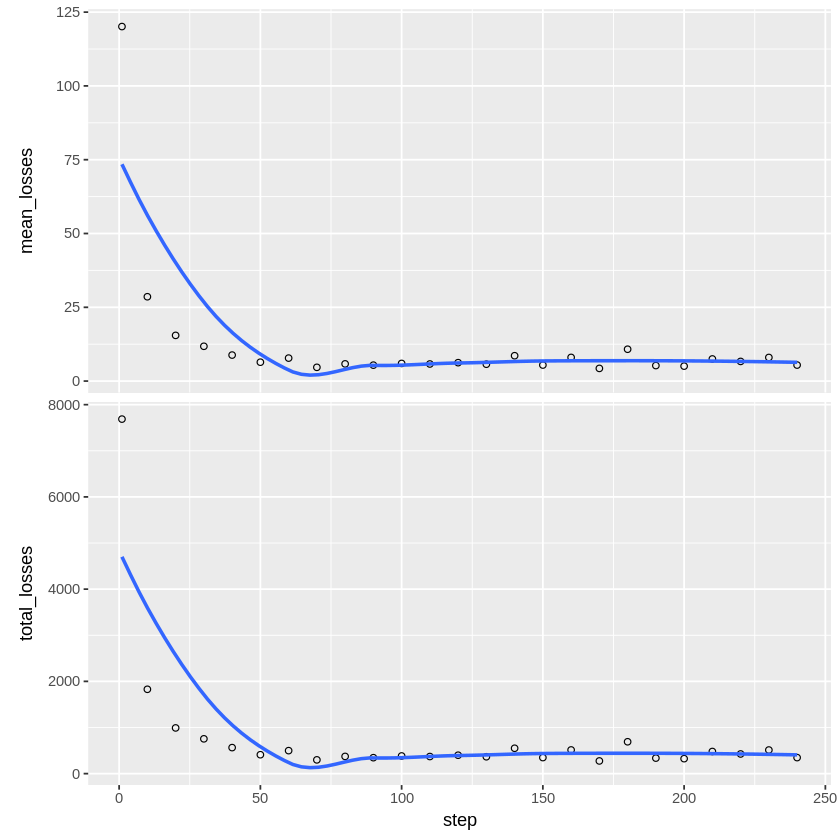

In [9]:
batch_size = 64
num_epochs = 2

unlink(model_dir, recursive = TRUE)

history <- train(
    model, 
    input_fn = data_input_fn(train_data, batch_size = batch_size, num_epochs = num_epochs, shuffle = TRUE)
)

plot(history)

### 2.2. Evaluate the trained estimator

In [10]:
evaluate(
    model, 
    input_fn = data_input_fn(eval_data, batch_size = batch_size)
)

label/mean,average_loss,global_step,prediction/mean,loss
7.235921,1.307004,241,7.04769,83.46671


### 2.3. Export trained estimator

In [11]:
feature_spec <- list()
for (i in 1:length(header)) {
    column <- header[i]
    if (column %in% features) {
        
        default_value = 'NA'
        column_type <- types[i]
        
        if (column_type != 'character'){
            default_value = 0
        }
        
        default_tensor <- tf$constant(value = default_value, shape = shape(1, 1))
        feature_spec[[column]] <- tf$placeholder_with_default(
            input = default_tensor, shape = shape(NULL, 1))
    }   
}  
            
serving_input_receiver_fn <- tf$estimator$export$build_raw_serving_input_receiver_fn(feature_spec)

saved_model_dir = paste0(model_dir, '/export')
export_savedmodel(model, saved_model_dir, serving_input_receiver_fn = serving_input_receiver_fn)
print(paste("Model exported to:", saved_model_dir))

[1] "Model exported to: models/tf_babyweight_estimator/export"


## 3. Submit a Training Job to AI Platform
In order to train your TensorFlow estimator in at scale using AI Platform Training, you need to write your training implementation in a [model_trainer.R](src/tensorflow/model_trainer) file. The file includes the code in the previous cells to create, train, evaluate, and export the TensorFlow dnn_linear_combined_regressor model.

The job will take several minutes to complete ...

In [13]:
setwd("src/tensorflow")
getwd()

cloudml_train('model_trainer.R', region = REGION)

setwd("../..")
getwd()

[1] "/home/jupyter/cloudml-samples/notebooks/R/src/tensorflow"

Submitting training job to CloudML...
Job 'cloudml_2019_07_25_123936933' successfully submitted.

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/cloudml_2019_07_25_123936933?project=r-on-gcp

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcloudml_2019_07_25_123936933&project=r-on-gcp

Check job status with:     job_status("cloudml_2019_07_25_123936933")

Collect job output with:   job_collect("cloudml_2019_07_25_123936933")

After collect, view with:  view_run("runs/cloudml_2019_07_25_123936933")



[1] "/home/jupyter/cloudml-samples/notebooks/R"

Verify the trained model in GCS after the job finishes

In [21]:
model_name <- 'tf_babyweight_estimator'
gcs_model_dir <- paste0("gs://", BUCKET_NAME, "/models/", model_name)
gsutil_exec("ls", gcs_model_dir, echo = TRUE)

gs://r-on-gcp/models/tf_babyweight_estimator/saved_model.pb
gs://r-on-gcp/models/tf_babyweight_estimator/variables.data-00000-of-00001
gs://r-on-gcp/models/tf_babyweight_estimator/variables.index


## 4. Deploy the trained model to AI Platform Prediction
If you train your model using the model_trainer.R in AI Platform, it will upload the saved model to GCS. 

However, if you train your model locally and have your saved model locally, you need to upload it to GCS.

### (Optional) 4.0. Upload the saved model to GCS

In [ ]:
model_name <- 'tf_babyweight_estimator'
gcs_model_dir <- paste0("gs://", BUCKET_NAME, "/models/", model_name)
gsutil_exec("cp", "-r", saved_model_dir, gcs_model_dir)

### 4.1. Create a model

In [ ]:
gcloud_exec("ai-platform", "models", "list")

# Create model
model_name <- 'tf_babyweight_estimator'
gcloud_exec("ai-platform", "models", "create", model_name, "--regions", REGION)

In [17]:
# List models
gcloud_exec("ai-platform", "models", "list", "--filter","name~tf_babyweight_estimator")

NAME                     DEFAULT_VERSION_NAME
tf_babyweight_estimator  v01


### 4.2. Create a model version 

In [ ]:
# Create version
model_version <- 'v01'
framework <- 'tensorflow'
runtime_version <- '1.14'

gcloud_exec("ai-platform", "versions", "create", model_version, 
            "--model", model_name, 
            "--framework", framework,
            "--runtime-version", runtime_version,
            "--origin", gcs_model_dir
           )

In [16]:
# List versions
gcloud_exec("ai-platform", "versions", "list", "--model", model_name)

NAME  DEPLOYMENT_URI                                STATE
v01   gs://r_on_gcp/models/tf_babyweight_estimator  READY


## 5. Invoke the Model API for Predictions

In [20]:
library("rjson")

model_version <- 'v01'

instances_string <- '
[
    {
        "is_male": ["TRUE"],
        "mother_age": [28],
        "mother_race": ["8"],
        "plurality": [1],
        "gestation_weeks":  [18],
        "mother_married": ["TRUE"],
        "cigarette_use": ["FALSE"],
        "alcohol_use": ["FALSE"]
     }    
]
'

instances <- jsonlite::fromJSON(instances_string, simplifyVector = FALSE)
predictions <- cloudml_predict(instances, model_name, version = model_version, verbose = TRUE)
print(paste("Estimated weight(s):", predictions))

Prediction Request:

{"is_male":["TRUE"],"mother_age":[28],"mother_race":["8"],"plurality":[1],"gestation_weeks":[18],"mother_married":["TRUE"],"cigarette_use":["FALSE"],"alcohol_use":["FALSE"]}



[1] "Estimated weight(s): list(list(predictions = 4.55018138885498))"


# License

Authors: Daniel Sparing & Khalid Salama

---
**Disclaimer**: This is not an official Google product. The sample code provided for an educational purpose.

---

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.